In [1]:
# PLOT OF NIRHISS, SUPREME-SPOON, TRANSITSPECTROSCOPY TRANSMISSION SPECTRA

import pickle
import os, sys
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt

'/Users/belugawhale/Documents/GitHub/wasp39b_paper/data/'

def load_plt_params():
    """ Load in plt.rcParams and set (based on paper defaults).
    """
    params = Table.read('/Users/belugawhale/Documents/GitHub/wasp39b_paper/scripts/rcParams.txt', format='csv')
    for i, name in enumerate(params['name']):
        try:
            plt.rcParams[name] = float(params['value'][i])
        except:
            plt.rcParams[name] = params['value'][i]
    return params

def load_parula():
    """ Load in custom parula colormap.
    """
    colors = np.load('/Users/belugawhale/Documents/GitHub/wasp39b_paper/data/parula_colors.npy')
    return colors

def pipeline_dictionary():
    """ Loads in the custom colors for the paper figures.
    """
    pipeline_dict = {}
    pipelines = Table.read('/Users/belugawhale/Documents/GitHub/wasp39b_paper/data/pipelines.csv', format='csv')

    # Sets the initials key for each pipeline
    for i, name in enumerate(pipelines['initials']):
        pipeline_dict[name] = {}
        pipeline_dict[name]['color'] = pipelines['color'][i]
        pipeline_dict[name]['name'] = pipelines['name'][i]
        pipeline_dict[name]['filename'] = pipelines['filename'][i]

    return pipeline_dict

def convolve_model(filename, R=300):
    model = np.loadtxt(filename)

    R0=3000.0 #cross-section resolution
    xker = np.arange(1000)-500
    sigma = (R0/R)/(2.* np.sqrt(2.0*np.log(2.0)))
    yker = np.exp(-0.5 * (xker / sigma)**2.0)
    yker /= yker.sum()
    model_to_plot=np.convolve(model[:,1],yker,mode='same') #convolving
    return model[:,0], model_to_plot


def convolve_model_xy(y, R=300):
    R0=3000.0 #cross-section resolution
    xker = np.arange(1000)-500
    sigma = (R0/R)/(2.* np.sqrt(2.0*np.log(2.0)))
    yker = np.exp(-0.5 * (xker / sigma)**2.0)
    yker /= yker.sum()
    model_to_plot=np.convolve(y,yker,mode='same') #convolving
    return model_to_plot

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name,
                                                                                            a=minval,
                                                                                            b=maxval),cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def avg_lightcurves(i, data, err, idx_oot, per=5):
    """
    Creates averaged spectroscopic light curves across 'per' number of
    channels.
    """

    flux  = np.zeros((per*2+1, len(data['time'])))
    model = np.zeros((per*2+1, len(data['time'])))
    error = np.zeros((per*2+1, len(data['time'])))
    fnorm = np.zeros((per*2+1, len(data['time'])))
    wrange = np.zeros(per*2+1)

    for j in range(i-per, i+per+1):
        flux[j-(i-per)]  = data['lc_w{}'.format(j)]
        model[j-(i-per)] = data['combined_model_w{}'.format(i)]

        eind = np.where(err[1] <=
                        data['w{}'.format(j)][0].value)[0][0]

        error[j-(i-per)] = err[3][:,eind]
        fnorm[j-(i-per)] = err[2][:,eind]
        wrange[j-(i-per)] = data['w{}'.format(j)][0].value

    wrange = np.sort(wrange)
    wmed = wrange[5]
    low,upp = wrange[5]-wrange[0], wrange[-1]-wrange[5]
    lim = np.round(np.nanmedian([low,upp]),3)

    e = (np.sqrt(np.nansum(error,axis=0))/len(error))/np.nanmax(fnorm)
    f = np.nanmean(flux, axis=0)
    m = np.nanmean(model, axis=0)

    f /= np.nanmedian(f[idx_oot])
    m /= np.nanmedian(m[idx_oot])

    return f, e, m, wmed, lim

def get_MAD_sigma(x, median):
    """
    Wrapper function for transitspectroscopy.utils.get_MAD_sigma to estimate
    the noise properties of the light curves.

    Parameters
    ----------
    x : np.ndarray
    median : np.ndarray
    """
    mad = np.nanmedian( np.abs ( x - median ) )

    return 1.4826*mad


# set the matplotlib parameters
load_plt_params();


In [2]:
# Load in the HST data from Wakeford + 2018
hst = Table.read('/Users/belugawhale/Documents/GitHub/wasp39b_paper/data/ts/WASP-39b_Wakeford_2018_AJ.csv', 
                 format='csv',
                 comment='#')
hst_err = np.sqrt(2) * hst['Rp/R*'] * hst['Rp/R* error'] * 100 # propagates err

In [3]:
# Load in the HST data from Wakeford + 2018
hst2 = Table.read('wasp39b.txt', 
                 format='ascii',
                 comment='#')

In [4]:
plt.rcParams['font.size'] = 14

/var/folders/9s/jb487nv52hs8n0q5ftmb1lk80000gn/T/ipykernel_49545/1726473574.py:121: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('/Users/belugawhale/Documents/niriss_real/wasp39/nature_submission/transmission_spectrum_nature.jpg',


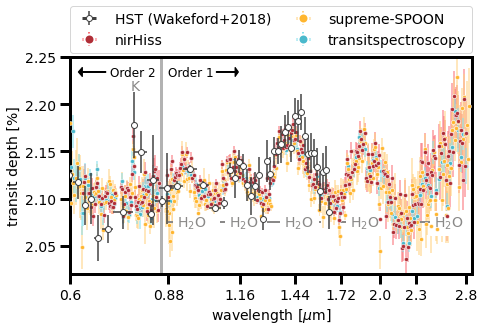

In [5]:
# Create the figure environment
fig = plt.figure(figsize=(7.20472,4))
fig.set_facecolor('w')

ecolors = ['#fa7178', '#ffd283', '#86dfed']

# Load in the HST data from Wakeford + 2018
hst = Table.read('/Users/belugawhale/Documents/GitHub/wasp39b_paper/data/ts/WASP-39b_Wakeford_2018_AJ.csv', 
                 format='csv',
                 comment='#')
hst_err = np.sqrt(2) * hst['Rp/R*'] * hst['Rp/R* error'] * 100 # propagates err

# Plots the HST data
plt.errorbar(hst['Wavelength microns'],
             hst['Rp/R*']**2*100,
             yerr=hst_err*np.sqrt(2),
             xerr=hst['Wavelength bin size microns'],
             marker='o', linestyle='', ms=6,
             markeredgecolor='#404040', ecolor='#404040',
             color='w', lw=1.5, markeredgewidth=1,
             zorder=100, label='HST (Wakeford+2018)')

# Load in colors and filenames
pipeline_dict = pipeline_dictionary()

# Select the pipelines to plot (nirhiss, supreme-spoon, transitspectroscopy)
pipelineorder = ['CMADF', 'MCR', 'NE']

# Set alpha value and zorder for each plotted spectrum
alpha = [0.6,1.0,0.9]
zorder=[10,9,8]

ms = 6

for i in range(len(pipelineorder)):

    # Reads in the transmission spectrum
    fn = pipeline_dict[pipelineorder[i]]['filename']
    tab = Table.read(os.path.join('/Users/belugawhale/Documents/GitHub/wasp39b_paper/data/ts', fn), 
                     format='csv', comment='#')
    color = pipeline_dict[pipelineorder[i]]['color']
    label = pipeline_dict[pipelineorder[i]]['name']

    # Plots each order separately
    for order in [1,2]:

        # Assigns wuality flags for plotting per order
        if order==2:
            q = (tab['quality'] == 0) & (tab['order'] == order)
            label=''
        else:
            q = tab['wave'] > 0.87
            label=label

        # Plots the transmission spectrum
        plt.errorbar(tab['wave'][q], tab['dppm'][q]/1e4,
                     yerr=tab['dppm_err'][q]/1e4,
                     xerr=tab['wave_error'][q],
                     markeredgecolor='w', color=color,
                     ecolor=ecolors[i], alpha=0.7,
                     linestyle='', marker='o', ms=ms-2,
                     markeredgewidth=0.5)

        # Plots the marker in slightly larger size with no alpha (for ease of
        #   reading the figure)
        plt.errorbar(tab['wave'][q], tab['dppm'][q]/1e4,
                     markeredgecolor='w', color=color,
                     ecolor=ecolors[i], markeredgewidth=0.5,
                     linestyle='', marker='o', ms=ms-2, zorder=zorder[i])

        # Plots the same points but bigger (for ease of reading the point size
        #   in the legend)
        plt.errorbar(tab['wave'][q], tab['dppm'][q]/1,
                     yerr=tab['dppm_err'][q]/1,
                     xerr=tab['wave_error'][q],
                     markeredgecolor='w', color=color,
                     ecolor=ecolors[i], linestyle='', marker='o',
                     label=label, ms=10, lw=2, markeredgewidth=2)

# Label some of the obvious features
lcolor = '#8a8988'
plt.text(s='K', color=lcolor, x=0.76, y=2.215)
x = [0.91, 1.115, 1.38, 1.78, 2.47]
rmin = [0.03, 0.04, 0.09, 0.08, 0.2]
rmax = [0.1, 0.13, 0.21, 0.24, 0.1]
for i in range(len(x)):
    plt.text(s=r'H$_2$O', x=x[i], y=2.07, color=lcolor, backgroundcolor='w')
    plt.hlines(y=2.075, xmin=x[i]-rmin[i], xmax=x[i]+rmax[i], color=lcolor, lw=2)

# Creates the dividing 'Order 1/Order 2' vertical line and text
plt.axvline(0.855, color='#404040', zorder=1, alpha=0.4, lw=3)
plt.text(s='Order 2', x=0.7, y=2.23, fontsize=12)
plt.arrow(0.69, 2.234, -0.06, 0., head_width=0.01, head_length=0.01, fc='k', ec='k')
plt.text(s='Order 1', x=0.88, y=2.23, fontsize=12)
plt.arrow(1.06, 2.234, 0.08, 0., head_width=0.01, head_length=0.015, fc='k', ec='k')

# Sets the x and y labels
plt.xlabel('wavelength [$\mu$m]')
plt.ylabel('transit depth [%]')

# Sets the x-limit, x-scale, and x-ticks
plt.xscale('log')
plt.xlim(0.6,2.86)
xticks = np.append(np.linspace(0.6,2,6), np.linspace(2.3,2.8,2))
xticks = np.round(xticks,2)
plt.xticks(xticks, labels=np.round(xticks,2))

# Sets the y-limit
plt.ylim(2.02,2.25)

# Creates the legend
leg = plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
             ncol=2, mode="expand", borderaxespad=0.,
             fontsize=14)
# Increases markersize in the legend
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)

plt.minorticks_off()

plt.savefig('/Users/belugawhale/Documents/niriss_real/wasp39/nature_submission/transmission_spectrum_nature.jpg', 
            dpi=300, rasterize=True,
            bbox_inches='tight')
#plt.savefig('/Users/belugawhale/Documents/niriss_real/wasp39/paper_figures/transmission_spectrum.pdf', 
#            dpi=300, rasterize=True,
#            bbox_inches='tight')

/var/folders/9s/jb487nv52hs8n0q5ftmb1lk80000gn/T/ipykernel_49545/3722537643.py:109: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('/Users/belugawhale/Desktop/helium.png',


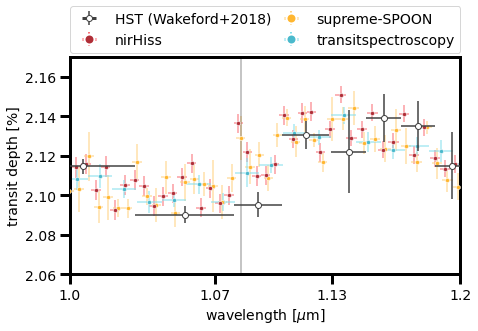

In [14]:
# Create the figure environment
fig = plt.figure(figsize=(7,4))
fig.set_facecolor('w')

ecolors = ['#fa7178', '#ffd283', '#86dfed']

# Load in the HST data from Wakeford + 2018
hst = Table.read('/Users/belugawhale/Documents/GitHub/wasp39b_paper/data/ts/WASP-39b_Wakeford_2018_AJ.csv', 
                 format='csv',
                 comment='#')
hst_err = np.sqrt(2) * hst['Rp/R*'] * hst['Rp/R* error'] * 100 # propagates err

# Plots the HST data
plt.errorbar(hst['Wavelength microns'],
             hst['Rp/R*']**2*100,
             yerr=hst_err*np.sqrt(2),
             xerr=hst['Wavelength bin size microns'],
             marker='o', linestyle='', ms=6,
             markeredgecolor='#404040', ecolor='#404040',
             color='w', lw=1.5, markeredgewidth=1,
             zorder=100, label='HST (Wakeford+2018)')

# Load in colors and filenames
pipeline_dict = pipeline_dictionary()

# Select the pipelines to plot (nirhiss, supreme-spoon, transitspectroscopy)
pipelineorder = ['CMADF', 'MCR', 'NE']

# Set alpha value and zorder for each plotted spectrum
alpha = [0.6,1.0,0.9]
zorder=[10,9,8]

ms = 6

for i in range(len(pipelineorder)):

    # Reads in the transmission spectrum
    fn = pipeline_dict[pipelineorder[i]]['filename']
    tab = Table.read(os.path.join('/Users/belugawhale/Documents/GitHub/wasp39b_paper/data/ts', fn), 
                     format='csv', comment='#')
    color = pipeline_dict[pipelineorder[i]]['color']
    label = pipeline_dict[pipelineorder[i]]['name']

    # Plots each order separately
    for order in [1,2]:

        # Assigns wuality flags for plotting per order
        if order==2:
            q = (tab['quality'] == 0) & (tab['order'] == order)
            label=''
        else:
            q = tab['wave'] > 0.87
            label=label

        # Plots the transmission spectrum
        plt.errorbar(tab['wave'][q], tab['dppm'][q]/1e4,
                     yerr=tab['dppm_err'][q]/1e4,
                     xerr=tab['wave_error'][q],
                     markeredgecolor='w', color=color,
                     ecolor=ecolors[i], alpha=0.7,
                     linestyle='', marker='o', ms=ms-2,
                     markeredgewidth=0.5)

        # Plots the marker in slightly larger size with no alpha (for ease of
        #   reading the figure)
        plt.errorbar(tab['wave'][q], tab['dppm'][q]/1e4,
                     markeredgecolor='w', color=color,
                     ecolor=ecolors[i], markeredgewidth=0.5,
                     linestyle='', marker='o', ms=ms-2, zorder=zorder[i])

        # Plots the same points but bigger (for ease of reading the point size
        #   in the legend)
        plt.errorbar(tab['wave'][q], tab['dppm'][q]/1,
                     yerr=tab['dppm_err'][q]/1,
                     xerr=tab['wave_error'][q],
                     markeredgecolor='w', color=color,
                     ecolor=ecolors[i], linestyle='', marker='o',
                     label=label, ms=10, lw=2, markeredgewidth=2)


# Sets the x and y labels
plt.xlabel('wavelength [$\mu$m]')
plt.ylabel('transit depth [%]')

# Sets the x-limit, x-scale, and x-ticks
plt.xscale('log')
plt.xlim(1.0,1.2)
xticks = np.linspace(1,1.2,4)
xticks = np.round(xticks,2)
plt.xticks(xticks, labels=np.round(xticks,2))

plt.axvline(1.083, color='#404040', alpha=0.4)


# Sets the y-limit
plt.ylim(2.06,2.17)

# Creates the legend
leg = plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
             ncol=2, mode="expand", borderaxespad=0.,
             fontsize=14)
# Increases markersize in the legend
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)

plt.minorticks_off()


plt.savefig('/Users/belugawhale/Desktop/helium.png',
            dpi=300, rasterize=True,
            bbox_inches='tight')

In [10]:
from astropy import units

In [13]:
(1083*units.nm).to(units.micron)

<Quantity 1.083 micron>

In [38]:
locs.write('/Users/belugawhale/Desktop/niriss_species.txt', format='ascii',
           overwrite=True)